# Classify Videos with Keras

This notebook explores using Keras to classify videos. First, you need to collect some images of different sports to train our model on. There are various options to do this. One approach is to use google images. Check out this guide here: https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/. Once collected, store them in a path such as data/sports/[name of_sport]

## Load data

Let's load our images

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

#set a random seed to ensure replicability
np.random.seed(32)

datagen_train = ImageDataGenerator(validation_split=0.2)

data = datagen_train.flow_from_directory(
    'data/sports',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = datagen_train.flow_from_directory(
    'data/sports',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')


Using TensorFlow backend.


Found 1124 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


Let's explore our data set

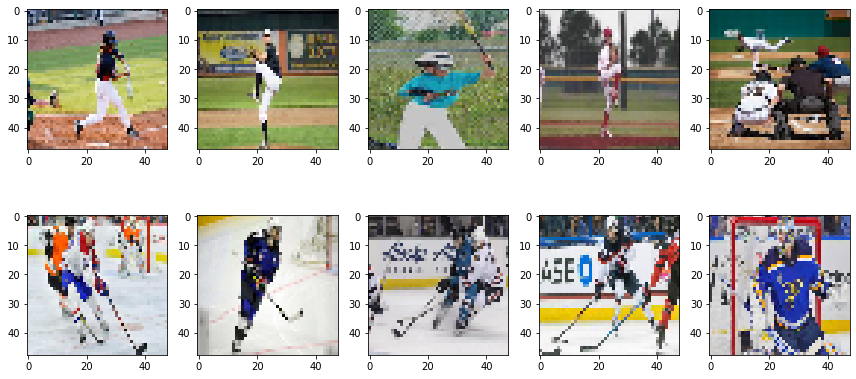

In [3]:
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import load_img, img_to_array

pic_size = 48

plt.figure(0, figsize=(12,20))

counter = 0

for folder in os.listdir("data/sports/"):
    for i in range(1,6):
        counter = counter + 1
        plt.subplot(7,5,counter)
        img = load_img("data/sports/" + folder + "/" + os.listdir(base_path + folder)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)

plt.tight_layout()
plt.show()

In [4]:
data.class_indices

{'baseball': 0, 'hockey': 1}

# Train Model

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.pooling import AveragePooling2D
from keras.applications import ResNet50
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD

import numpy as np
import argparse
import pickle
import os

We will use Transfer Learning to accelerate our model accuracy, using the ResNet50 imagenet model

In [6]:
baseModel = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
 
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(data.class_indices), activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

W1023 15:30:59.018364 11280 deprecation_wrapper.py:119] From C:\Users\jdeha\Anaconda3\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1023 15:30:59.035459 11280 deprecation_wrapper.py:119] From C:\Users\jdeha\Anaconda3\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1023 15:30:59.040460 11280 deprecation_wrapper.py:119] From C:\Users\jdeha\Anaconda3\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1023 15:30:59.075447 11280 deprecation_wrapper.py:119] From C:\Users\jdeha\Anaconda3\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W

Now we compile our model and train our image classifier

In [9]:
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-6)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

epochs = 5

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=data,
                                steps_per_epoch=data.n//data.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

W1023 16:33:20.930314 11280 deprecation.py:323] From C:\Users\jdeha\Anaconda3\envs\keras\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
35/35 [==============================] - 218s 6s/step - loss: 0.7467 - acc: 0.5911 - val_loss: 0.6320 - val_acc: 0.6055

Epoch 00001: val_acc improved from -inf to 0.60547, saving model to model_weights.h5
Epoch 2/5
35/35 [==============================] - 193s 6s/step - loss: 0.5856 - acc: 0.7089 - val_loss: 0.5289 - val_acc: 0.6855

Epoch 00002: val_acc improved from 0.60547 to 0.68548, saving model to model_weights.h5
Epoch 3/5
35/35 [==============================] - 191s 5s/step - loss: 0.4818 - acc: 0.7620 - val_loss: 0.4683 - val_acc: 0.7500

Epoch 00003: val_acc improved from 0.68548 to 0.75000, saving model to model_weights.h5
Epoch 4/5
35/35 [==============================] - 208s 6s/step - loss: 0.3993 - acc: 0.8224 - val_loss: 0.4489 - val_acc: 0.7661

Epoch 00004: val_acc improved from 0.75000 to 0.76613, saving model to model_weights.h5
Epoch 5/5
35/35 [==============================] - 206s 6s/step - loss: 0.3990 - acc: 0.8109 - val_loss: 0.4028 - val_acc: 0.81

# Video Classification
Now let's test this out with our video. We will use the cv2 package for loading and examining the video.

In [1]:
# import the necessary packages
from keras.models import load_model
from collections import deque
import numpy as np
import argparse
import pickle
import cv2

Using TensorFlow backend.


In [2]:
model = load_model("model_weights.h5")

W1026 22:10:48.795252 14804 deprecation_wrapper.py:119] From C:\Users\jdeha\Anaconda3\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1026 22:10:48.846933 14804 deprecation_wrapper.py:119] From C:\Users\jdeha\Anaconda3\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1026 22:10:48.878070 14804 deprecation_wrapper.py:119] From C:\Users\jdeha\Anaconda3\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1026 22:10:48.878070 14804 deprecation_wrapper.py:119] From C:\Users\jdeha\Anaconda3\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



This function loads the video, then loops through frame by frame, applying the classification to each frame. These are stored in a queue and the average is used for smoothing purposes

In [3]:
# initialize the image mean for mean subtraction along with the
# predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")

pred_queue = deque(maxlen=30)

vs = cv2.VideoCapture("both_1.mp4")

writer = None
(W, H) = (None, None)

values = ['baseball', 'hockey']

# loop over frames from the video file stream
while True:
    # read the next frame from the file
    (grabbed, frame) = vs.read()

    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break

    # if the frame dimensions are empty, grab them
    if W is None or H is None:
        (H, W) = frame.shape[:2]

    # clone the output frame, then convert it from BGR to RGB
    # ordering, resize the frame to a fixed 224x224, and then
    # perform mean subtraction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean
    
    # make predictions on the image and add it to the queue
    prediction = model.predict(np.expand_dims(frame, axis=0))[0]
    pred_queue.append(prediction)
    # get the mean of the predictions for smoothing
    results = np.array(pred_queue).mean(axis=0)
    i = np.argmax(results)
    label = values[i]
    # write out the predicted text of the activity on the output frame
    text = "activity: {}".format(label)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
        1.25, (0, 255, 0), 5)

    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter("file_test.mp4", fourcc, 30,
            (W, H), True)

    # write the output frame to disk
    writer.write(output)

    # show the output image
    cv2.imshow("Output", output)
    key = cv2.waitKey(1) & 0xFF

# release the file pointers
writer.release()
vs.release()